In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt

from pyaw.swarm import save_SW_EFIx_TCT16, save_SW_MAGx_HR_1B

# basic assignment of variables

In [2]:
start_time = '20160311T064700'
end_time = '20160311T064900'
satellite = 'A'
sdir = Path("D:/cleo/master/pyaw/data/swarm/miles2018")
sfn_efi16 = Path("efi16.pkl")
sfn_vfm50 = Path("vfm50.pkl")

# download data

In [3]:
save_SW_EFIx_TCT16(start_time, end_time, satellite, sdir,
                   sfn_efi16)
save_SW_MAGx_HR_1B(start_time, end_time, satellite, sdir,
                   sfn_vfm50)

D:\cleo\master\pyaw\data\swarm\miles2018\efi16.pkl already exists, skip save.
D:\cleo\master\pyaw\data\swarm\miles2018\vfm50.pkl already exists, skip save.


# read data

In [ ]:
df_e = pd.read_pickle(Path(sdir)/Path(sfn_efi16))
df_b = pd.read_pickle(Path(sdir)/Path(sfn_vfm50))
timestamps_e = df_e.index.values

# get rotation matrix

vfm2nec, nec2vfm

In [5]:
VsatN = df_e['VsatN'].values
VsatE = df_e['VsatE'].values
Ehx = df_e['Ehx'].values
Ehy = df_e['Ehy'].values

In [6]:
theta = np.arctan(VsatE/VsatN)
cos_theta = np.cos(theta)
sin_theta = np.sin(theta)
# Stack components to construct the rotation matrices
rotation_matrix = np.array([
    [cos_theta, sin_theta],
    [-sin_theta, cos_theta]
])
# Transpose axes to create a (3, 2, 2) array
rotation_matrix_2d_nec2vfm = np.transpose(rotation_matrix, (2, 0, 1))
rotation_matrix_2d_vfm2nec = rotation_matrix_2d_nec2vfm.transpose(0, 2, 1)
del rotation_matrix

In [7]:
def do_rotation(vectors1,vectors2,rotation_matrix):
    vectors12 = np.stack((vectors1,vectors2),axis=1)
    vectors12_rotated = np.einsum('nij,nj->ni', rotation_matrix, vectors12)
    return vectors12_rotated[:,0],vectors12_rotated[:,1]

## rotation matrix test

In [8]:
Vsat_vfm_x,Vsat_vfm_y = do_rotation(VsatN,VsatE,rotation_matrix_2d_nec2vfm)
np.max(abs(Vsat_vfm_y)),np.all(np.isclose(Vsat_vfm_y,0,atol=1e-3))

(0.00012207031, True)

In [9]:
test_vsat_n,test_vsat_e = do_rotation(Vsat_vfm_x,Vsat_vfm_y,rotation_matrix_2d_vfm2nec)
np.max(abs(test_vsat_n - VsatN)),np.all(np.isclose(test_vsat_n - VsatN,0,atol=1e-3))

(0.0009765625, True)

## get E_nec_ne using rotation matrix

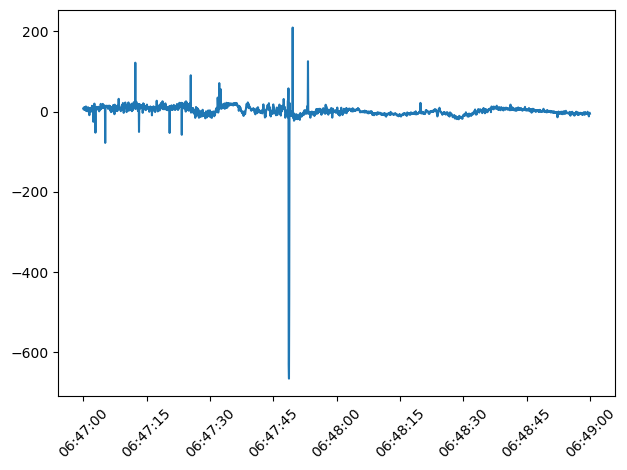

In [10]:
plt.plot(timestamps_e, Ehx)
plt.xticks(rotation=45)
plt.tight_layout()  # Ensures everything fits within the figure
plt.show()

In [11]:
np.std(Ehx),np.mean(Ehx),np.max(Ehx),np.min(Ehx)

(26.03453, 1.4860274, 209.64946, -665.1797)

### preprocess before rotation

In [12]:
def set_outliers_nan(array,std_times: float = 1.0, print_: bool = True):
    array_copy = array.copy()
    threshold = std_times * np.std(array_copy)
    bursts = np.abs(array_copy - np.mean(array_copy)) > threshold
    array_copy[bursts] = np.nan
    return array_copy

Ehx_set_outliers_nan = set_outliers_nan(Ehx)
Ehy_set_outliers_nan = set_outliers_nan(Ehy)

In [13]:
def get_array_interpolated(x,y):
    """
    :param x: ndarray consisting of np.datetime64. Specifically in this notebook the dtype of the array is np.datetime64[ns]
    :param y:
    :return:
    """
    y_copy = y
    # Mask for missing values
    mask = np.isnan(y_copy)
    # Interpolate
    y_copy[mask] = interpolate.interp1d(x[~mask].astype('int'), y_copy[~mask], kind='linear')(
        x[mask].astype('int'))
    return y_copy

In [14]:
Ehx_set_outliers_nan_interpolated = get_array_interpolated(timestamps_e, Ehx_set_outliers_nan)
Ehy_set_outliers_nan_interpolated = get_array_interpolated(timestamps_e, Ehy_set_outliers_nan)

In [15]:
Eh_nec_n,Eh_nec_e = do_rotation(Ehx_set_outliers_nan_interpolated,Ehy_set_outliers_nan_interpolated,rotation_matrix_2d_vfm2nec)

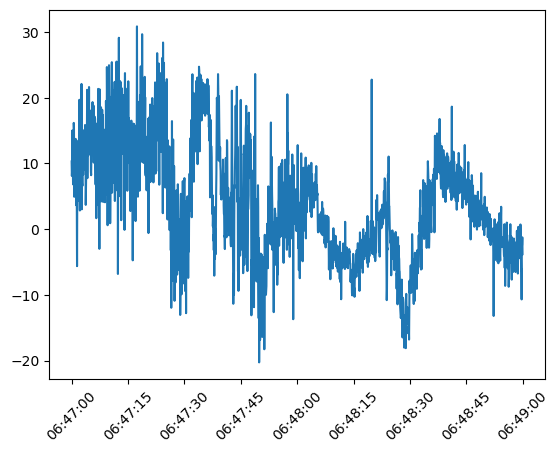

In [16]:
plt.plot(timestamps_e, Eh_nec_n)
plt.xticks(rotation=45)
plt.show()

# magnetic field

original and after rotation

In [17]:
Bx = df_e['Bx'].values
By = df_e['By'].values

B_nec_n, B_nec_e = do_rotation(Bx,By,rotation_matrix_2d_vfm2nec)

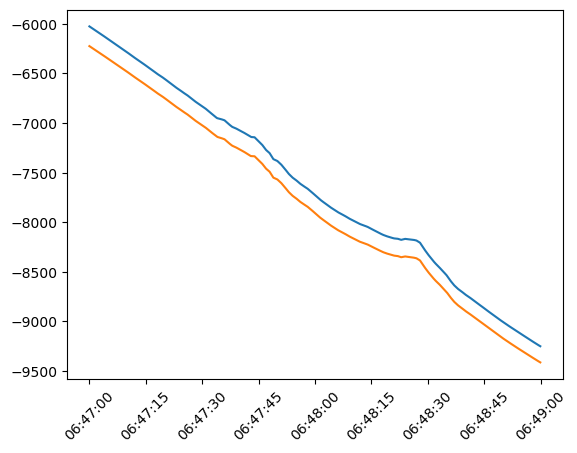

In [18]:
plt.plot(timestamps_e, Bx)
plt.plot(timestamps_e, B_nec_n)
plt.xticks(rotation=45)
plt.show()

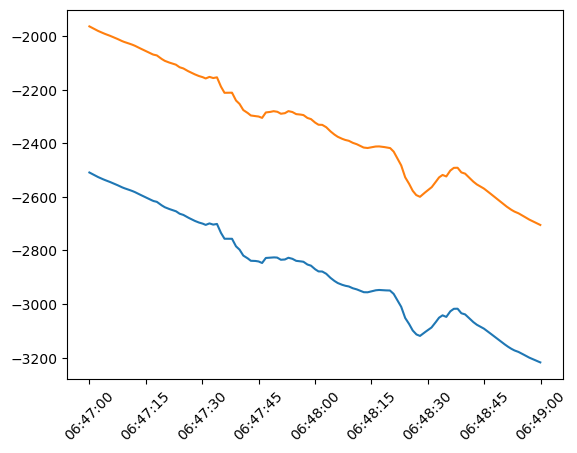

In [19]:
plt.plot(timestamps_e, By)
plt.plot(timestamps_e, B_nec_e)
plt.xticks(rotation=45)
plt.show()

## IGRF13

In [27]:
latitudes = df_e['Latitude'].values
longitudes = df_e['Longitude'].values
radiuses = df_e['Radius']/1e3  # km

In [30]:
from igrf13 import igrf_utils
# from importlib import reload
# reload(igrf_utils)

igrf_b_nec_n,igrf_b_nec_e,_ = igrf_utils.get_igrf13_b_nec(timestamps_e, latitudes,longitudes, radiuses,igrf13shc_path="./igrf13/IGRF13.shc")

the whole loop takes time: 4.53052282333374s


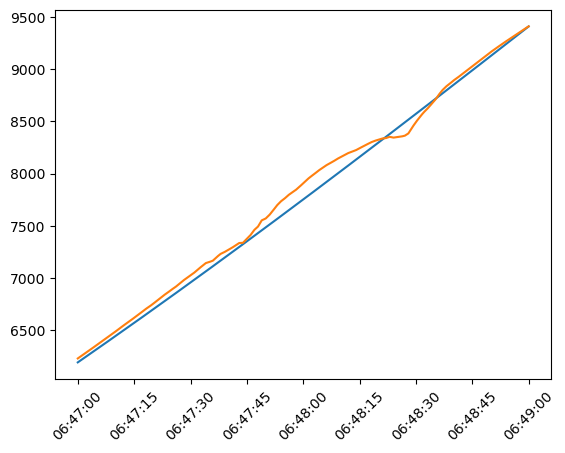

In [34]:
plt.plot(timestamps_e, igrf_b_nec_n)
plt.plot(timestamps_e, -B_nec_n)  # fixme:: why 'igrf_b_nec_n' and 'B_nec_n' have a negative sign difference?
plt.xticks(rotation=45)
plt.show()